### Uncomment and run the below code block if you do not already have the below libraries installed.

In [1]:
# !pip install sklearn
# !pip install pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import collections
import time
from sklearn import decomposition
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression 
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
print(sklearn.__version__)

1.0.2


In [4]:
# make sure your data matches the given name below, else edit it to desired name
# note: csv is assumed to be stored in /content/ . Change path if necessary
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MUM_data.csv')
# check that the data is imported properly
df.head()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
0,2,2,32,24,1024,32,35,128,2.2625
1,2,2,8,12,1024,32,35,64,2.2381
2,2,2,32,48,1024,64,82,64,2.3809
3,2,2,8,12,2048,32,20,64,2.2526
4,2,2,64,48,1024,64,20,64,2.3829


### Exploratory Data Analysis:

In [5]:
df.mean()

SM            3.951538
MM            1.446412
shader       26.057782
core         27.343896
spunit     1536.477167
l1           47.955266
latency      45.515377
dl2          96.208760
IPC           2.023505
dtype: float64

In [6]:
df.median()

SM            3.0000
MM            1.0000
shader       16.0000
core         24.0000
spunit     1536.0000
l1           32.0000
latency      35.0000
dl2         128.0000
IPC           1.8968
dtype: float64

In [7]:
df.tail()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
1068,15,1,8,24,2048,32,82,128,1.8955
1069,15,1,8,12,2048,64,35,128,1.8965
1070,15,1,8,24,1024,64,82,64,1.8956
1071,15,1,8,48,2048,32,82,64,1.8956
1072,15,1,8,12,1024,32,82,64,1.8956


In [8]:
df.describe()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
count,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000
mean,3.951538,1.446412,26.057782,27.343896,1536.477167,47.955266,45.515377,96.208760,2.023505
std,3.257236,0.528276,20.909195,14.895222,419.311460,16.007398,26.338532,32.014241,0.377115
min,2.000000,1.000000,8.000000,12.000000,1024.000000,32.000000,20.000000,64.000000,1.413900
25%,2.000000,1.000000,8.000000,12.000000,1024.000000,32.000000,20.000000,64.000000,1.793000
50%,3.000000,1.000000,16.000000,24.000000,1536.000000,32.000000,35.000000,128.000000,1.896800
75%,3.000000,2.000000,32.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,2.267500
max,15.000000,3.000000,64.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,3.761600


In [9]:
df.shape

(1073, 9)

###Functions

In [10]:
import warnings
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statistics
import statsmodels.formula.api as smf

from yellowbrick.regressor import ResidualsPlot

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
#functions
def x_y_split(dataset, data_start, data_end, target_index):
    x_data = dataset[:, data_start:data_end+1]
    y_data = dataset[:, target_index]
    return x_data, y_data

def exclude_from_set(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] != value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def x_y_split_by_value(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] == value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

def group_dataset(dataset, target_index):
    group_data = dataset[:, target_index]
    return group_data

In [12]:
#machine learning functions
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit, LeavePGroupsOut, GridSearchCV,GroupKFold,KFold, GroupShuffleSplit, LeavePOut
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut, ShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import math
from sklearn.svm import SVC, SVR
from matplotlib import rcParams
#write functions

import warnings
warnings.filterwarnings('ignore')
# to filter out warnings at this time

def outer_cross_val(X, Y, validation_method, model, params ,\
                    model_type = 'Regression', min_samples = 10):
    #X - test data
    #Y - test data true results
    #groups - what to split the test data based on
    #validation_method - how to split the data for validation
    #model_params: model, model_type, params
    #model: the model used for machine learning
    #params: Pass in to nested function for GridSearchCV
    #model_type: Regression or Classification
    #min_samples: min number of samples on the test set to consider the model
    #function returns the best model overall and a collection of scoring and data
    print("Outer Cross Validation")
    
    labels_matrix = np.unique(Y)
    #print(labels_matrix)
    #print(len(labels_matrix))
    consolidated_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    best_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    #based on the model type, score differently'
    if model_type == 'Regression':
        best_score = 10000 #using root mean squared error, so lower score is better
    elif model_type == 'Classification':
        best_score = 0 #using accuracy, so higher score is better
    count = 0
    total_score = 0
    total_r2 = 0
    for train_index, test_index in validation_method.split(X, Y):
        #for each group split, do a nested cross validation
        # print('train_index: ', train_index)
        # print('test_index: ', test_index)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # nested_groups = groups[train_index]
        
        #optmized model from training set (validation done in nested function)
        best_nested_model = nested_cross_val(X_train, Y_train, \
                                            validation_method, model, params)
        #print the parameters for the model in the nested 
        
        print('best_nested_model: ', best_nested_model)
        #fitting the model with training data
        best_nested_model.fit(X_train,Y_train)
        
        Y_pred = best_nested_model.predict(X_test)
        
        # Y_pred_q = np.round_(Y_pred, decimals = 0)
        
        #nested_score = metrics.mean_squared_error(Y_test, Y_pred)
        #print(math.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
        
        nested_score = rsme(Y_test, Y_pred)
        print('nested_score: ', nested_score)
        nested_r2 = metrics.r2_score(Y_test,Y_pred)
        print('nested_r2: ', nested_r2)
        # nested_accuracy = metrics.accuracy_score(Y_test, Y_pred_q)
        # nested_f1 = metrics.f1_score(Y_test, Y_pred, average='weighted')
        #compile all results for the confusion matrix
        # consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
        #                                     labels=labels_matrix)
        print('Y_test: ', Y_test)
       # print(min_samples)
        print('best_score: ', best_score)
        if model_type == 'Regression':
            #if regression, compare mean squared error, the lower the better
            if best_score > nested_score and len(Y_test) >= min_samples:
            #compare metrics if the number of test cases are greater than 10:
                best_model_overall = best_nested_model
                best_score = nested_score
                best_R2 = nested_r2
                best_x_train = X_train
                best_y_train = Y_train
                best_x_test = X_test
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_score
            total_r2 += nested_r2
        elif model_type == 'Classification':
            #if classification, compare accuracy
            if best_score < nested_accuracy and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_accuracy
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_accuracy
            
                
        count += 1
        
    average_score = total_score/count
    average_r2 = total_r2/count
    
    if model_type == 'Reg_R2' or 'Regression':
        rcParams['figure.figsize'] = 5,5
        fig, ax = plt.subplots()
        ax.scatter(best_y_test,best_y_pred, alpha=.5,c = 'black')
        
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

#         # now plot both limits against eachother
#         ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        #obtain m (slope) and b(intercept) of linear regression line
#         m, b = np.polyfit(best_y_test, best_y_pred, 1)

#         #add linear regression line to scatterplot 
#         ax.plot(best_y_test, m*best_y_test+b)

        sns.regplot(best_y_test, best_y_pred,color='black',ci=95, scatter_kws={'alpha':0.01})
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_xlabel('Actual Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title('MUM')
#         fig.savefig(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\%r_reg.svg' % subscore)
        plt.show()

        rcParams['figure.figsize'] = 6,4
        visualizer = ResidualsPlot(best_model_overall,hist = True)
        visualizer.fit(best_x_train, best_y_train)  # Fit the training data to the visualizer
        visualizer.score(best_x_test, best_y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure
        
        # visualizer = ResidualsPlot(best_model_overall,hist = False,qqplot=True)
        # visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
        # visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
        # visualizer.show()                 # Finalize and render the figure

    final_scoring = best_score, average_score, best_y_test, best_y_pred, best_R2, average_r2
  
    return best_model_overall, final_scoring


def nested_cross_val(X, Y, validation_method, model, params):
    #print("Inner Cross Validation")
    #X, Y, cross validation split method object, model
    # use GridSearchCV to look for the best model
    test_model = GridSearchCV(model, params, cv = validation_method.split(X, Y)).fit(X, Y)
    #print(test_model.best_estimator_)
    #print(test_model.scorer_)
    return test_model.best_estimator_
    
def rsme(predictions, target):
    #root squared mean error
    return np.sqrt(((predictions - target) **2).mean())

#calculate the accuracy from a confusion matrix
def accuracy_from_confusion_matrix(matrix):
    tp = np.diag(matrix).sum() #true positive
    total = matrix.sum()
    #print(tp)
    #print(total)
    return(tp*1.0/total)

#use the binom class from scipi
from scipy.stats import binom

def binomial_range(x, N, confidence_level = 0.95):
    #print("Calculate Binomal")
    #c_high = 1 - (confidence_level/2)
    #c_low = 1 - (confidence_level/2)
    prob = (x*1.0)/N
    #use the scipy binom.interval function to get the confidence range
    nums = binom.interval(confidence_level, N, prob)
    return nums[0]/N, nums[1]/N
    #exact_confidence_interval(x, N, c_high, c_low)
    
def matrix_scores(matrix):
    print("Extracting Confidence Intervals scores for the matrix")
    #do count through the matrix for the confidence scores.
    #matrix is expected to be a n x n matrix
    matrix_results = []
    for i in range(len(matrix[0])):
        #print(i)
        tp = matrix[i,i]
        fn = np.sum(matrix[i]) - tp
        fp = np.sum(matrix[:, i]) -tp
        #print("tp %d" %tp)
        #print("fp %d" %fp)
        #print("fn %d" %fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        print("overall precision: %.8f, recall: %.8f" % (precision, recall))
        #with binomial ranges
        precision_b_low, precision_b_high = binomial_range(tp, tp+fp)
        recall_b_low, recall_b_high = binomial_range(tp, tp+fn)
        print("precision range for %i: %.8f to %.8f" % (i +1, precision_b_low, precision_b_high))
        print("recall range for %i: %.8f to %.8f" % (i +1, recall_b_low, recall_b_high))
        matrix_results.append([[precision_b_low, precision_b_high], [recall_b_low, recall_b_high]])
    return matrix_results

###SVR

In [13]:
data_arr = df.to_numpy()
X, Y = x_y_split(data_arr, 0, 7, 8)
print(Y)
# Y = Y.astype(float) # cast Y as floats
# labels_for_matrix = np.unique(Y)
#generate features for the paper draft, and include reasons why that was done 

[2.2625 2.2381 2.3809 ... 1.8956 1.8956 1.8956]


In [14]:
print({'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]})

{'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06], 'C': [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}


Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100000, gamma=1e-06)
nested_score:  0.1077863072278435
nested_r2:  0.923826528146757
Y_test:  [2.1211 2.2526 2.4026 2.3118 2.2675 2.3786 2.2381 2.4147 2.4085 2.4074
 2.2143 2.4135 2.2443 2.3784 2.2634 2.3829 2.4147 2.3199 2.2962 2.2526
 2.1211 2.3829 2.3809 2.2652 2.4143 2.4176 2.415  2.3005 2.3829 2.1322
 2.2224 2.2381 2.2143 2.1171 2.3031 2.2143 2.429  2.2224 2.3057 2.0483
 2.2658 2.4147 2.3118 2.4147 2.3786 2.2224 2.1182 2.2634 2.2443 2.415
 2.429  2.2381 2.4115 2.2443 2.2634 2.2675 2.3181 2.3118 2.4176 2.2526
 2.3057 2.3005 2.2634 2.4147 2.2224 2.2675 2.2634 2.2143 2.4115 2.2526
 2.4085 2.2649 2.0557 2.3809 2.2143 2.4143 1.5852 1.4139 1.7997 1.8907
 1.8923 1.8907 1.5842 1.7977 1.5929 1.7997 1.5938 1.4165 1.5842 1.6358
 1.8882 1.6426 1.6426 1.8027 1.5821 1.6571 1.8913 1.8935 1.6359 1.5759
 1.7997 1.6426 1.4721 1.8911 1.5759 1.6399 1.8017 1.6426 1.7986 1.7986
 1.5947 1.4165 1.6571 1.8911 1.5821 1.4658 1.8007 1.

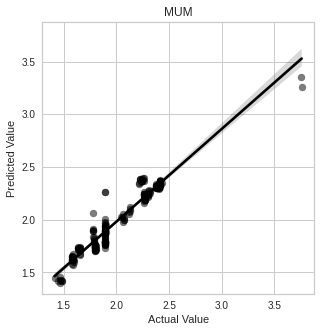

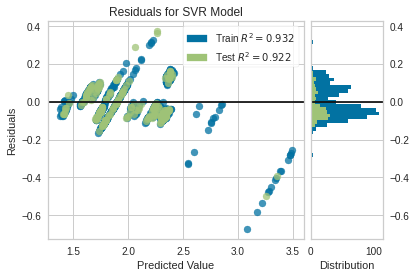

best score: 0.095381
best R2_score: 0.921830
average score: 0.105620 
average R2: 0.921185 


In [15]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=10000, gamma=1e-06)
nested_score:  0.09712742752543047
nested_r2:  -0.10133674734551934
Y_test:  [2.2625 2.2381 2.3809 2.2526 2.3829 2.2685 2.4143 2.4147 2.3199 2.4176
 2.3809 2.4147 2.2652 2.3181 2.2443 2.2685 2.0638 2.1211 2.2143 2.1325
 2.2675 2.3005 2.0735 2.0638 2.4147 2.2526 2.2224 2.3829 2.3031 2.4135
 2.2443 2.2649 2.4026 2.2443 2.2652 2.2634 2.2224 2.2649 2.4099 2.3824
 2.2526 2.3784 2.2143 2.2652 2.3809 2.3829 2.2625 2.3118 2.429  2.2675
 2.2625 2.3784 2.4085 2.4074 2.4115 2.3786 2.2143 2.3809 2.2634 2.2381
 2.4147 2.4085 2.2443 2.2649 2.3786 2.377  2.2649 2.4085 2.2381 2.2526
 2.2652 2.2649 2.2224 2.4074 2.1322 2.2658 2.0483 2.2381 2.2143 2.4135
 2.2443 2.4143 2.3784 2.4115 2.3199 2.2381 2.2381 2.2634 2.3829 2.2649
 2.2652 2.4143 2.2634 2.3829 2.0638 2.4147 2.3199 2.3784 2.4099 2.2962
 2.4176 2.429  2.2962 2.3786 2.3809 2.2381 2.2443 2.4135 2.2526 2.2652
 2.429  2.2652 2.1286 2.1211 2.2625 2.2381 2.252

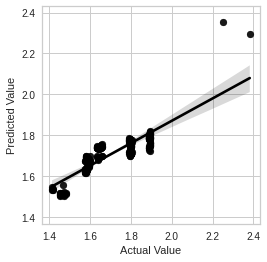

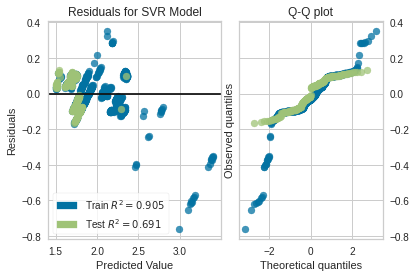

best score: 0.084780
best R2_score: 0.691099
average score: 0.527844 
average R2: -2.976943 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold()
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100000, gamma=1e-06)
nested_score:  0.11250958859335836
nested_r2:  0.91979588190289
Y_test:  [2.2381 2.2652 2.2443 2.2224 2.2443 2.2649 2.2443 2.4099 2.429  2.3786
 2.2634 2.2443 2.2649 2.2649 2.2381 2.2526 2.2658 2.2143 2.4143 2.4115
 2.3199 2.2381 2.2634 2.2649 2.3784 2.2381 2.2652 2.2625 2.377  2.4147
 2.4147 2.3786 2.3786 2.2381 2.377  2.1322 2.4026 2.4099 2.2143 2.2658
 2.2224 2.3829 2.4135 2.1182 2.075  2.2625 2.2649 2.2224 2.2143 2.415
 2.2634 2.415  2.0483 2.1211 2.3101 2.2685 2.415  2.2652 2.4099 2.429
 2.4026 2.4143 2.4026 2.377  2.2143 2.2224 2.2675 2.2526 2.1322 2.377
 2.2675 2.3829 2.2224 2.2625 2.2143 2.4115 2.4085 2.2649 2.1171 2.3824
 2.1286 2.2443 2.2625 2.3784 2.3824 1.6571 1.5792 1.8017 1.8911 1.589
 1.793  1.5932 1.7997 1.5842 1.5989 1.5885 1.7973 1.8935 1.793  1.8935
 1.8913 1.7973 1.7977 1.5852 1.8027 1.6358 1.8923 1.7997 1.5792 1.5792
 1.5989 1.6553 1.6426 1.8911 1.6426 1.5759 1.6426 1.803

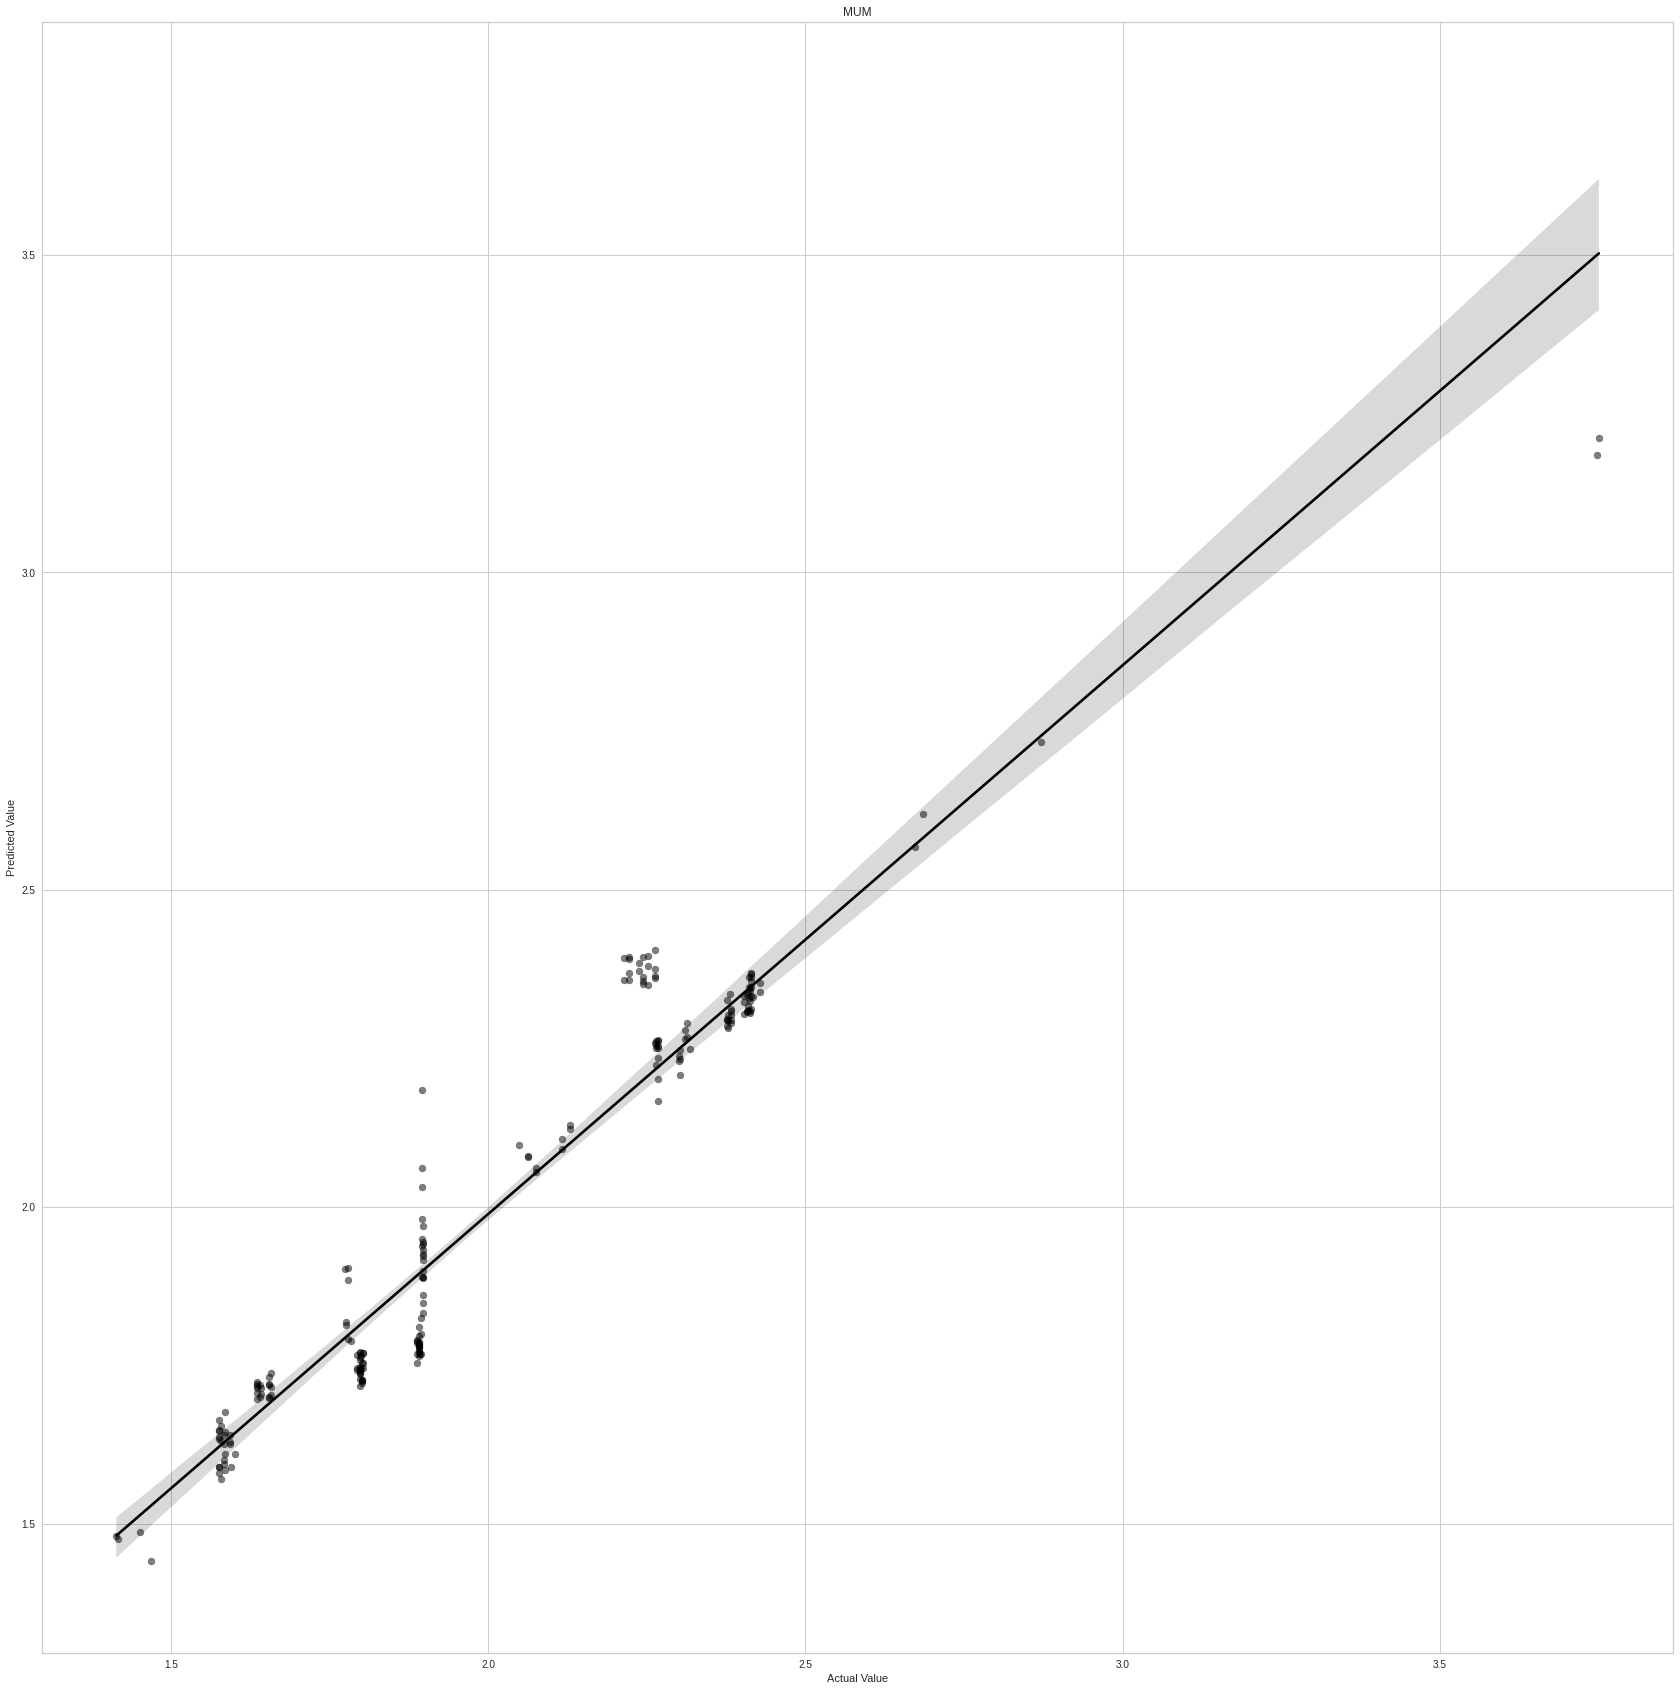

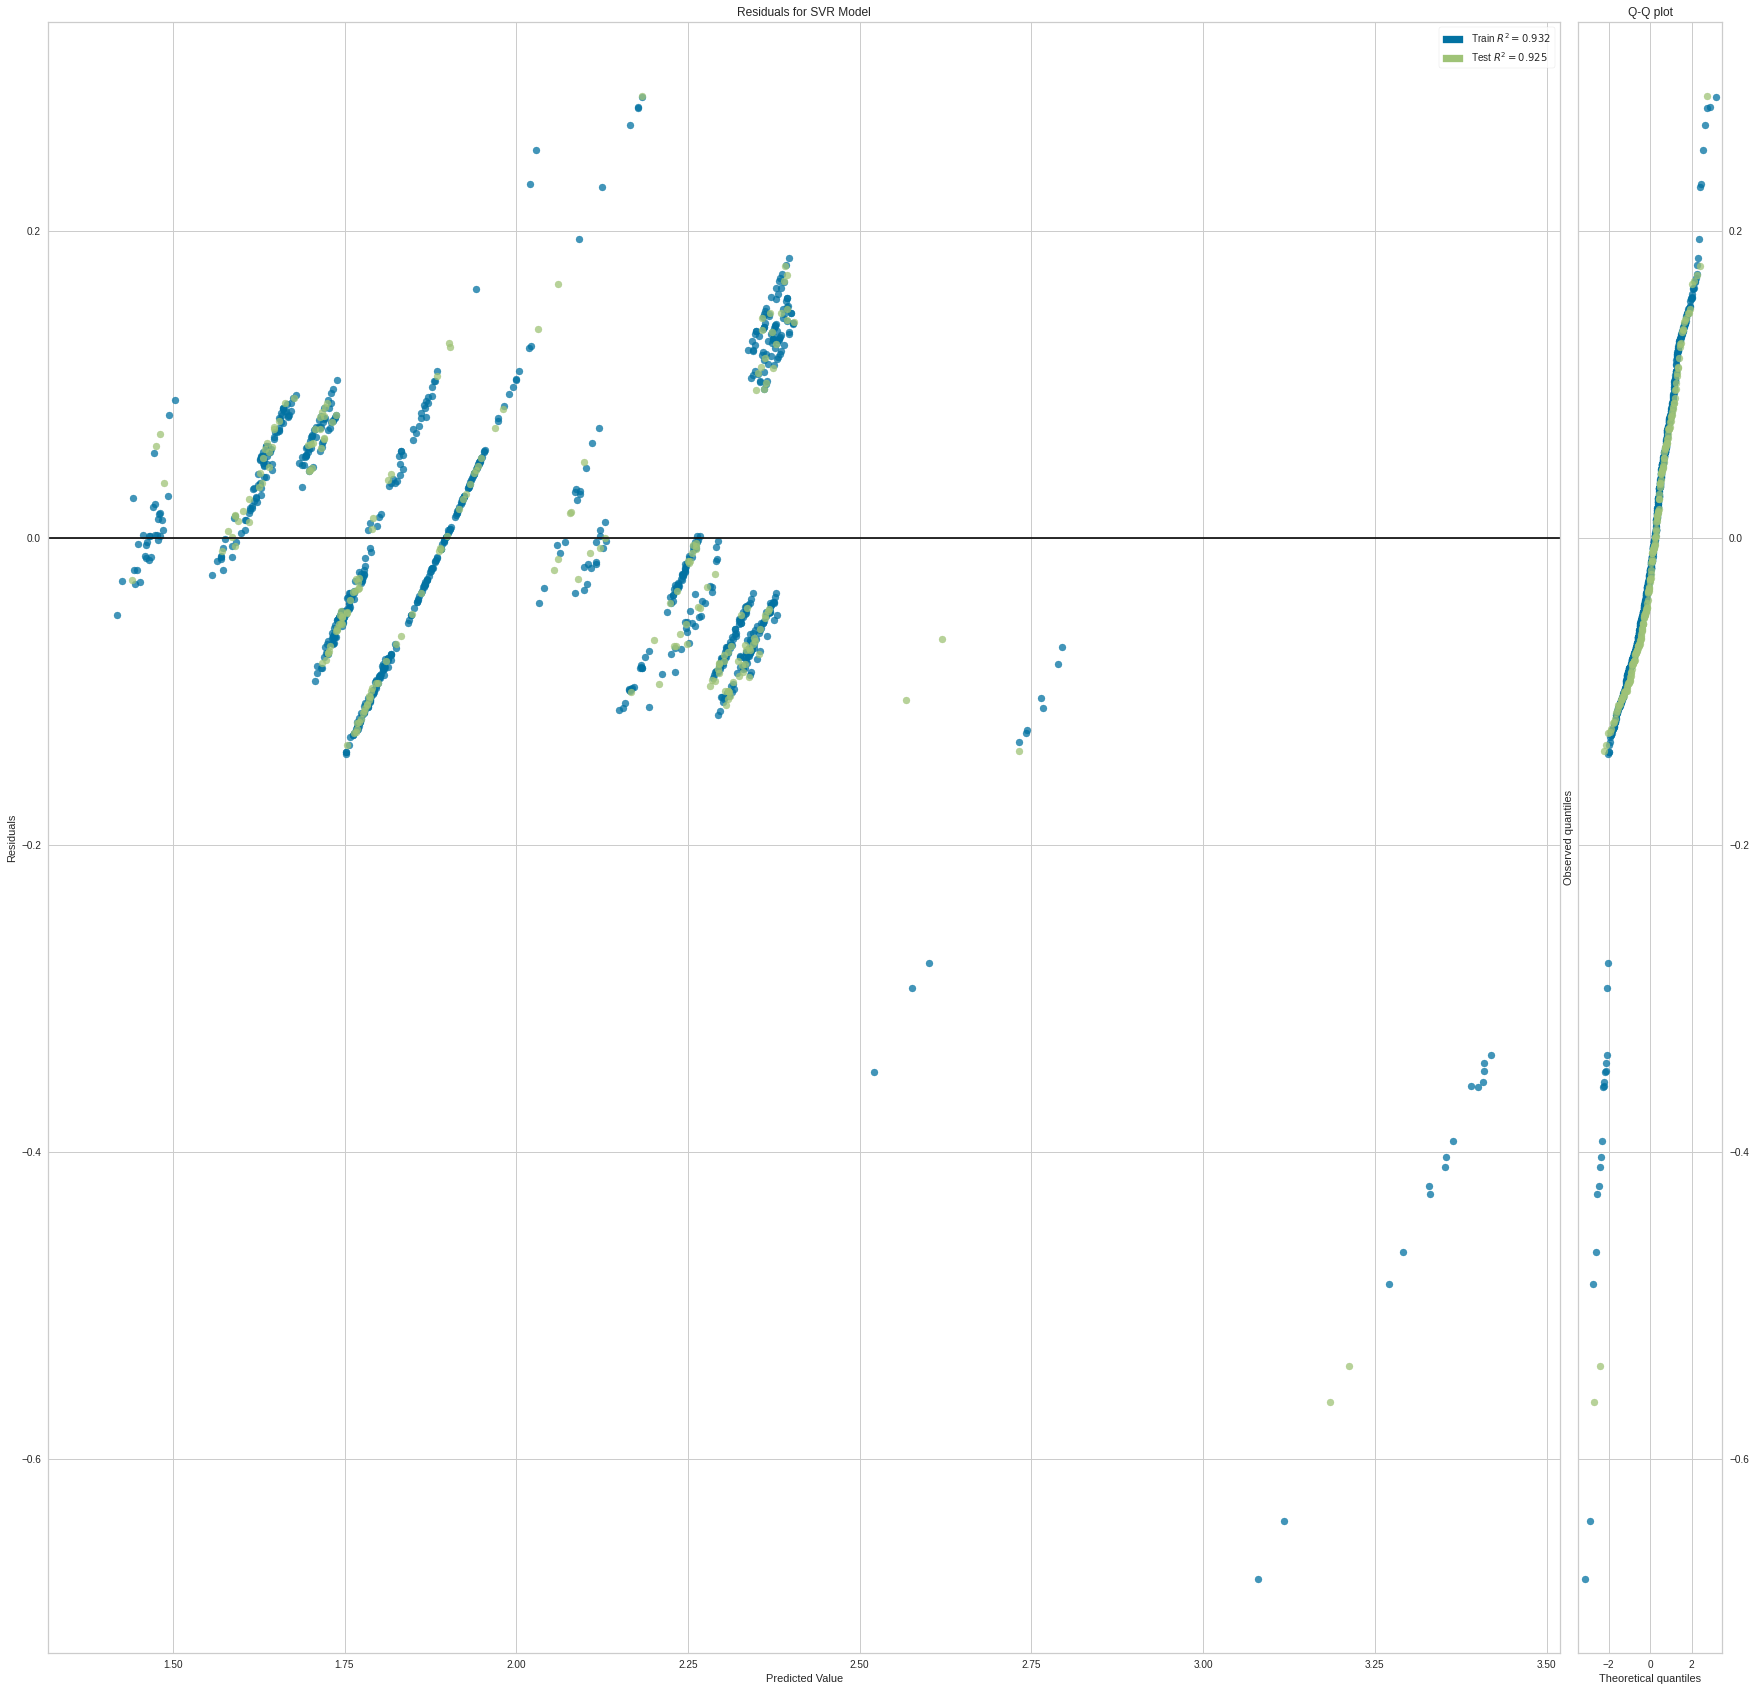

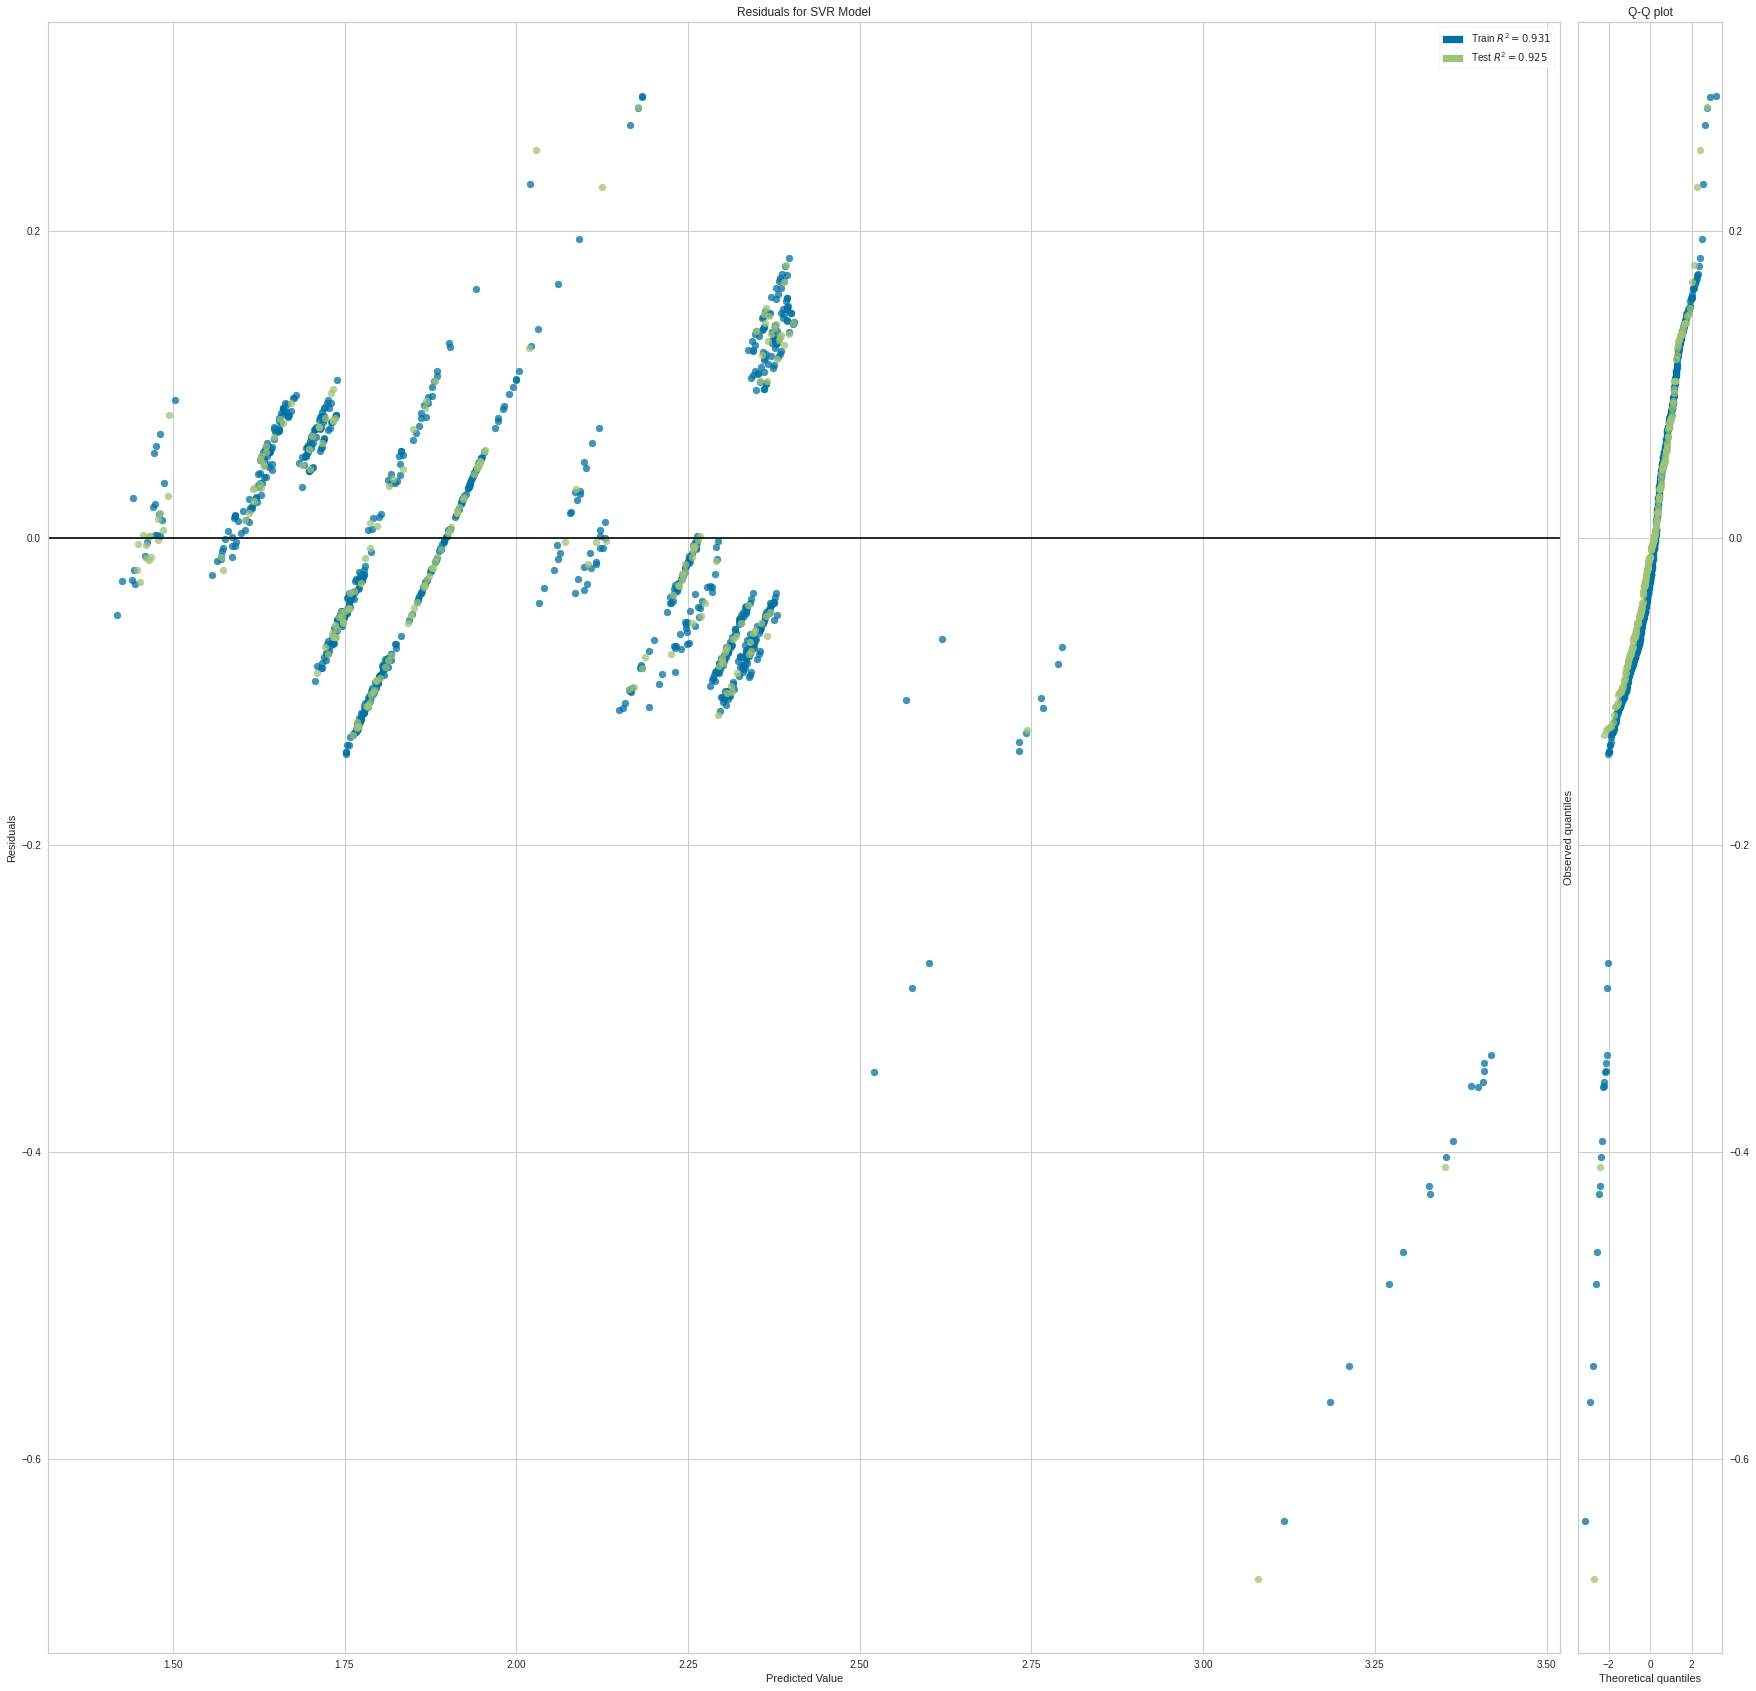

best score: 0.096373
best R2_score: 0.925367
average score: 0.104529 
average R2: 0.922206 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)